## Learning Objectives

At the end of the experiment, you will be able to:

* perform data preprocessing, EDA and feature extraction on the Medical Q&A dataset
* load a pre-trained tokenizer
* finetune a GPT-2 language model for medical question-answering

## Dataset Description

The dataset used in this project is the *Medical Question Answering Dataset* ([MedQuAD](https://github.com/abachaa/MedQuAD/tree/master)). It includes medical question-answer pairs along with additional information, such as the question type, the question *focus*, its UMLS(Unified Medical Language System) details like - Concept Unique Identifier(*CUI*) and Semantic *Type* and *Group*.

To know more about this data's collection, and construction method, refer to this [paper](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-3119-4).

The data is extracted and is in CSV format with below features:

- **Focus**: the question focus
- **CUI**: concept unique identifier
- **SemanticType**
- **SemanticGroup**
- **Question**
- **Answer**

## Information

Healthcare professionals often have to refer to medical literature and documents while seeking answers to medical queries. Medical databases or search engines are powerful resources of upto date medical knowledge. However, the existing documentation is large and makes it difficult for professionals to retrieve answers quickly in a clinical setting. The problem with search engines and informative retrieval engines is that these systems return a list of documents rather than answers. Instead, healthcare professionals can use question answering systems to retrieve short sentences or paragraphs in response to medical queries. Such systems have the biggest advantage of generating answers and providing hints in a few seconds.

### Problem Statement

Fine-tune gpt2 model on medical-question-answering-dataset for performing response generation for medical queries.

### **GPT-2**

In recent years, the OpenAI GPT-2 exhibited an impressive ability to write coherent and passionate essays that exceeded what current language models can produce. The GPT-2 wasn't a particularly novel architecture - its architecture is very similar to the **decoder-only transformer**. The GPT2 was, however, a very large, transformer-based language model trained on a massive dataset.

Here, you are going to fine-tune the GPT2 model with the Medical data. Expected result should be that the model will be able to reply to the prompt related medical queries after fine-tuning.

To know more about GPT-2, refer [here](http://jalammar.github.io/illustrated-gpt2/).

The dataset consists of the following columns:

**Focus**: The medical topic (e.g., "Adult Acute Lymphoblastic Leukemia").

**CUI**: Concept Unique Identifier.

**SemanticType**: The type of medical entity (e.g., "T191").

**SemanticGroup**: A broader group categorizing the entity (e.g., "Disorders").

**Question**: The medical question related to the focus.

**Answer**: The corresponding answer for the medical question.

To fine-tune a GPT-2 model for medical question-answering based on this dataset, the general steps are as follows:

Steps for Fine-tuning GPT-2:
Data Preprocessing:

Concatenate the Question and Answer columns to create a text input-output pair for training GPT-2.
Tokenize the data appropriately using GPT-2 tokenizer.

**Model Setup:**

Load the pre-trained GPT-2 model from Hugging Face.
Configure the model for fine-tuning.
Fine-tuning:

Fine-tune the GPT-2 model using the prepared dataset.
Define a training loop to adjust the model parameters based on the dataset.

**Evaluation**:
Evaluate the model’s performance on a test set (or use cross-validation).

### Installing Dependencies

In [ ]:
%%capture
!pip -q uninstall pyarrow -y
!pip -q install pyarrow==15.0.2
!pip -q install datasets
!pip -q install accelerate
!pip -q install transformers

### <font color="#990000">Restart Session/Runtime</font>

### Import required packages

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from datasets import load_dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#@title Download the dataset
!wget -q https://cdn.iisc.talentsprint.com/AIandMLOps/MiniProjects/Datasets/MedQuAD.csv
!ls | grep ".csv"

MedQuAD.csv


** Read the MedQuAD.csv dataset **

**Hint:** `pd.read_csv()`

In [ ]:
df=pd.read_csv('MedQuAD.csv')
df.head()

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer
0,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,What is (are) Adult Acute Lymphoblastic Leukem...,Key Points - Adult acute lymphoblastic leukemi...
1,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,What are the symptoms of Adult Acute Lymphobla...,"Signs and symptoms of adult ALL include fever,..."
2,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,How to diagnose Adult Acute Lymphoblastic Leuk...,Tests that examine the blood and bone marrow a...
3,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,What is the outlook for Adult Acute Lymphoblas...,Certain factors affect prognosis (chance of re...
4,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,Who is at risk for Adult Acute Lymphoblastic L...,Previous chemotherapy and exposure to radiatio...


In [ ]:
df.shape

(16412, 6)

In [ ]:
df.describe()

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer
count,16398,15847,15815,15847,16412,16407
unique,5126,3329,14,1,14984,15809
top,Breast Cancer,C0039082,T047,Disorders,What causes Causes of Diabetes ?,This condition is inherited in an autosomal re...
freq,53,351,9651,15847,20,348


### Pre-processing and EDA

**Perform below operations on the dataset **

- Handle missing values
- Remove duplicates from data considering `Question` and `Answer` columns

- **Handle missing values**

Missing values per column:
Focus             14
CUI              565
SemanticType     597
SemanticGroup    565
Answer             5
dtype: int64


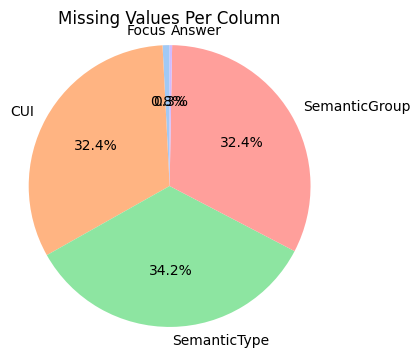

In [ ]:
# Count and display the number of missing values per column
missing_values_count = df.isnull().sum()

# Filter and display only columns that have missing values
missing_columns = missing_values_count[missing_values_count > 0]

print("Missing values per column:")
print(missing_columns)

plt.figure(figsize=(4, 4))
plt.pie(missing_columns, labels=missing_columns.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title("Missing Values Per Column")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
# To find the number of rows that have missing values in any column
rows_with_missing = df.isnull().any(axis=1).sum()

print(f"\nNumber of rows with missing values: {rows_with_missing}")


Number of rows with missing values: 602


In [ ]:
#Handle Missing Values
# Dropping rows where 'Answer' is missing since it's a critical field
data_cleaned = df.dropna(subset=['Answer'])

# Filling missing values in categorical columns with 'Unknown'
categorical_columns = ['Focus', 'CUI', 'SemanticType', 'SemanticGroup']
for column in categorical_columns:
    data_cleaned[column].fillna('Unknown', inplace=True)

In [ ]:
data_cleaned.shape

(16407, 6)

- **Remove duplicates from data considering `Question` and `Answer` columns**

In [ ]:
# YOUR CODE HERE
# Check for duplicates based on all columns
duplicates = data_cleaned.duplicated()
print(f"Number of duplicates: {duplicates.sum()}")

# Check for duplicates based on specific columns (e.g., 'Focus' and 'Question')
duplicates_specific = data_cleaned.duplicated(subset=['Question', 'Answer'])
print(f"Number of duplicates based on Question and Answer: {duplicates_specific.sum()}")

# Display duplicate rows
data_cleaned[duplicates_specific]

Number of duplicates: 48
Number of duplicates based on Question and Answer: 48


,Focus,CUI,SemanticType,SemanticGroup,Question,Answer
12540,Acromegaly,C0001206,T047,Disorders,What are the treatments for Acromegaly ?,"Currently, treatment options include surgical ..."
12654,Causes of Diabetes,C0011860,T047,Disorders,What causes Causes of Diabetes ?,Other types of diabetes have a variety of poss...
12659,"Diabetes, Heart Disease, and Stroke",C0038454,T047,Disorders,"What is (are) Diabetes, Heart Disease, and Str...","If you have diabetes, you are at least twice a..."
12668,"Diabetes, Heart Disease, and Stroke",C0038454,T047,Disorders,"What to do for Diabetes, Heart Disease, and St...","- If you have diabetes, you are at least twice..."
12706,Causes of Diabetes,C0011860,T047,Disorders,What is (are) Causes of Diabetes ?,Diabetes is a complex group of diseases with a...
12707,Causes of Diabetes,C0011860,T047,Disorders,What causes Causes of Diabetes ?,Type 1 diabetes is caused by a lack of insulin...
12708,Causes of Diabetes,C0011860,T047,Disorders,What causes Causes of Diabetes ?,Type 2 diabetesthe most common form of diabete...
12709,Causes of Diabetes,C0011860,T047,Disorders,What causes Causes of Diabetes ?,Insulin Resistance and Beta Cell Dysfunction H...
12710,Causes of Diabetes,C0011860,T047,Disorders,What causes Causes of Diabetes ?,Other types of diabetes have a variety of poss...
12711,Causes of Diabetes,C0011860,T047,Disorders,What causes Causes of Diabetes ?,Other types of diabetes have a variety of poss...


In [ ]:
# YOUR CODE HERE
# This is the same as the previous example
data_after_duplicate = data_cleaned.drop_duplicates(subset=['Question', 'Answer'], keep='first')

In [ ]:
print(f"Original shape: {df.shape}")
print(f"Shape after removing duplicates based on Focus and Question: {data_after_duplicate.shape}")

Original shape: (16412, 6)
Shape after removing duplicates based on Focus and Question: (16359, 6)


In [ ]:
data_after_duplicate.head()

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer
0,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,What is (are) Adult Acute Lymphoblastic Leukem...,Key Points - Adult acute lymphoblastic leukemi...
1,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,What are the symptoms of Adult Acute Lymphobla...,"Signs and symptoms of adult ALL include fever,..."
2,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,How to diagnose Adult Acute Lymphoblastic Leuk...,Tests that examine the blood and bone marrow a...
3,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,What is the outlook for Adult Acute Lymphoblas...,Certain factors affect prognosis (chance of re...
4,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,Who is at risk for Adult Acute Lymphoblastic L...,Previous chemotherapy and exposure to radiatio...


 Display the category name, and the number of records belonging to top 100 categories of `Focus` column **

In [ ]:
# Displaying the distinct categories of Focus column and the number of records belonging to each category
# Get the distinct categories in the 'Focus' column and their respective record counts
distinct_focus_categories = data_after_duplicate['Focus'].value_counts()

# Print each distinct category and its corresponding number of records
print("Distinct categories in the 'Focus' column and their counts:")
print(distinct_focus_categories)

Distinct categories in the 'Focus' column and their counts:
Focus
Breast Cancer                                                     53
Prostate Cancer                                                   43
Stroke                                                            35
Skin Cancer                                                       34
Alzheimer's Disease                                               30
                                                                  ..
Ectrodactyly cleft palate syndrome                                 1
Ectrodactyly and ectodermal dysplasia without cleft lip/palate     1
Ectopia pupillae                                                   1
Ectodermal dysplasia, hidrotic, Christianson-Fourie type           1
Thyroid cancer, follicular                                         1
Name: count, Length: 5126, dtype: int64


In [ ]:
# Displaying the distinct categories of Focus column and the number of records belonging to each category
# (Top 100 only)

# Top 100 Focus categories names
# Display the top 100 categories
top_100_focus_categories = distinct_focus_categories.head(100)

# Print the category names and their counts
print("Top 100 categories in the 'Focus' column:")
print(top_100_focus_categories)

Top 100 categories in the 'Focus' column:
Focus
Breast Cancer                           53
Prostate Cancer                         43
Stroke                                  35
Skin Cancer                             34
Alzheimer's Disease                     30
                                        ..
Cushing's Syndrome                      11
Liddle syndrome                         11
Greig cephalopolysyndactyly syndrome    11
Holt-Oram syndrome                      11
Hearing Loss                            10
Name: count, Length: 100, dtype: int64


### Create Training and Validation set

Create training and validation set

- Consider 4 samples per `Focus` category, for each top 100 categories, from the dataset (It will give 400 samples for training)

- Consider 1 sample per `Focus` category (different from training set), for each top 100 categories, from the dataset (It will give 100 samples for validation)

Explanation: Select Top 100 Categories:

We use the value_counts() method to get the top 100 most frequent categories in the Focus column. Filter the Dataset:

Only include the rows that correspond to the top 100 categories. Training Set:

We use groupby('Focus') to group the data by category, and within each group, we randomly select 4 samples using .sample(n=4). This creates 400 samples in total (4 samples × 100 categories). Validation Set:

After creating the training set, we select 1 different sample from each category (ensuring it's distinct from the training set). We achieve this by filtering out the training indices and sampling 1 different sample per category. Random State:

A fixed random_state is used to ensure reproducibility of the sampling. Output: Training set size: 400 samples (4 samples per category for 100 categories). Validation set size: 100 samples (1 different sample per category for 100 categories).

In [ ]:
# Step 1: Get the top 100 categories in the 'Focus' column
top_100_focus_categories = data_after_duplicate['Focus'].value_counts().head(100).index

# Step 2: Create the training set (4 samples per Focus category from the top 100 categories)
train_samples = []
for category in top_100_focus_categories:
    category_samples = data_after_duplicate[data_after_duplicate['Focus'] == category].sample(n=4, random_state=42)
    train_samples.append(category_samples)

# Concatenate all training samples into a single DataFrame
train_set = pd.concat(train_samples)

# Step 3: Create the validation set (1 sample per Focus category, different from training set)
validation_samples = []
for category in top_100_focus_categories:
    # Exclude training samples from validation selection
    remaining_samples = data_after_duplicate[(data_after_duplicate['Focus'] == category) & (~data_after_duplicate.index.isin(train_set.index))]
    category_validation_sample = remaining_samples.sample(n=1, random_state=42)
    validation_samples.append(category_validation_sample)

# Concatenate all validation samples into a single DataFrame
validation_set = pd.concat(validation_samples)

# Display the number of samples in each set
print(f"Training set has {len(train_set)} samples")
print(f"Validation set has {len(validation_set)} samples")


# Display the training set as a DataFrame
print("Training Set :")
display(train_set)

# Display the validation set as a DataFrame
print("\nValidation Set :")
display(validation_set)


Training set has 400 samples
Validation set has 100 samples
Training Set :


,Focus,CUI,SemanticType,SemanticGroup,Question,Answer
568,Breast Cancer,C0006142,T191,Disorders,Who is at risk for Breast Cancer? ?,Key Points - Avoiding risk factors and increas...
14925,Breast Cancer,C0006142,T191,Disorders,What is (are) Breast Cancer ?,A mammogram can often detect breast changes in...
14931,Breast Cancer,C0006142,T191,Disorders,What is (are) Breast Cancer ?,There are two types of breast-conserving surge...
561,Breast Cancer,C0006142,T191,Disorders,What are the symptoms of Breast Cancer ?,Signs of breast cancer include a lump or chang...
15450,Prostate Cancer,C0376358,T191,Disorders,What is (are) Prostate Cancer ?,Surgery is a common treatment for early stage ...
...,...,...,...,...,...,...
8507,Holt-Oram syndrome,C0265264,T019,Disorders,What are the treatments for Holt-Oram syndrome ?,These resources address the diagnosis or manag...
15133,Hearing Loss,C0011053,T033,Disorders,What are the treatments for Hearing Loss ?,Assistive Listening Devices Assistive listenin...
15126,Hearing Loss,C0011053,T033,Disorders,How to prevent Hearing Loss ?,Causes of Hearing Loss Hearing loss happens fo...
15130,Hearing Loss,C0011053,T033,Disorders,What is (are) Hearing Loss ?,Presbycusis is common in older adults. Presbyc...



Validation Set :


,Focus,CUI,SemanticType,SemanticGroup,Question,Answer
563,Breast Cancer,C0006142,T191,Disorders,What is the outlook for Breast Cancer ?,Certain factors affect prognosis (chance of re...
15448,Prostate Cancer,C0376358,T191,Disorders,What are the treatments for Prostate Cancer ?,"Surgery, radiation therapy, and hormonal thera..."
16079,Stroke,C0038454,T047,Disorders,What are the symptoms of Stroke ?,The signs and symptoms of a stroke often devel...
15525,Skin Cancer,C0007114,T191,Disorders,What are the treatments for Skin Cancer ?,Different types of treatment are available for...
14859,Alzheimer's Disease,C0002395,T046,Disorders,How to prevent Alzheimer's Disease ?,"Currently, no medicines or other treatments ar..."
...,...,...,...,...,...,...
12555,Cushing's Syndrome,C0010481,T047,Disorders,What is (are) Cushing's Syndrome ?,Cushing's syndrome is a hormonal disorder caus...
3606,Liddle syndrome,C0221043,T047,Disorders,What are the symptoms of Liddle syndrome ?,What are the signs and symptoms of Liddle synd...
2803,Greig cephalopolysyndactyly syndrome,C0265306,T019,Disorders,What are the symptoms of Greig cephalopolysynd...,What are the signs and symptoms of Greig cepha...
3034,Holt-Oram syndrome,C0265264,T019,Disorders,What are the symptoms of Holt-Oram syndrome ?,What are the signs and symptoms of Holt-Oram s...


### Pre-process `Question` and `Answer` text



- Combine `Question` and `Answer` for train and validation data as shown below:
    - sequence = *'\<question\>' + question-text + '\<answer\>' + answer-text + '\<end\>'*

- Join the combined text using '\n' into a single string for training and validation separately

- Save the training and validation strings as separate text files

Explanation: Combining Question and Answer:

The combine_question_answer function formats each row by combining the Question and Answer columns as:

Question TextAnswer Text Joining All Records:

We join all the combined strings using \n (newline) to create a single string for the training and validation data separately.

Saving to Files:

We write the final strings into training_data.txt and validation_data.txt files for training and validation data, respectively.

Output: training_data.txt: Contains the combined question and answer for all training samples, formatted as requested. validation_data.txt: Contains the combined question and answer for all validation samples.

- **Combine Question and Answer for train and val data**

- **Join the combined text using '\n' into a single string for training and validation separately**

In [ ]:
# Combine Questions and Answers for train and val data
## sequence = '<question> ' + question + ' <answer> ' + answer + ' <end>'

# Step 1: Combine Questions and Answers for train and val data
# Define a function to combine question and answer into the required format
def combine_question_answer(row):
    return f"<question> {row['Question']} <answer> {row['Answer']} <end>"

# Apply the function to both the training and validation sets
train_set['combined'] = train_set.apply(combine_question_answer, axis=1)
validation_set['combined'] = validation_set.apply(combine_question_answer, axis=1)

# Step 2: Join the combined text using '\n' into a single string for training and validation separately
train_combined_string = '\n'.join(train_set['combined'].tolist())
validation_combined_string = '\n'.join(validation_set['combined'].tolist())


- **Save the training and validation strings as text files**

In [ ]:

# Save the training and validation data as text files

# Step 3: Save the training and validation strings as text files
with open('training_data.txt', 'w', encoding='utf-8') as train_file:
    train_file.write(train_combined_string)

with open('validation_data.txt', 'w', encoding='utf-8') as val_file:
    val_file.write(validation_combined_string)

print("Training and validation data have been saved as 'training_data.txt' and 'validation_data.txt'.")

Training and validation data have been saved as 'training_data.txt' and 'validation_data.txt'.


Load pre-trained GPT2Tokenizer**

- Use checkpoint = "gpt2"

**Hint:** `GPT2Tokenizer.from_pretrained(...)`

The code sets the padding token to be the EOS token. This means that when the model needs to add extra tokens to make all sentences the same length (padding), it will use the "End of Sentence" token instead of another padding symbol.

In [ ]:
# Set up the tokenizer
# YOUR CODE HERE
# Load the pre-trained GPT2Tokenizer
checkpoint = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(checkpoint)

# Set the padding token to the EOS token
tokenizer.pad_token = tokenizer.eos_token

print(f"Tokenizer loaded: {tokenizer}")
print(f"Vocabulary size: {len(tokenizer)}")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Tokenizer loaded: GPT2Tokenizer(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
Vocabulary size: 50257


In [ ]:
# Check if the tokenizer loaded successfully
print(f"Tokenizer loaded: {checkpoint}")

# You can now use the tokenizer for encoding text
sample_text = "What are the symptoms of flu?<answer>Fever, cough, and sore throat are common.<end>"
encoded_input = tokenizer(sample_text)

# Display the tokenized output
print("Tokenized output:", encoded_input)

Tokenizer loaded: gpt2
Tokenized output: {'input_ids': [2061, 389, 262, 7460, 286, 6562, 30, 27, 41484, 29, 37, 964, 11, 22094, 11, 290, 19597, 13589, 389, 2219, 29847, 437, 29], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Tokenize train and validation data

- Use the loaded pre-trained tokenizer
- Use training and validation data saved in text files


Explanation: Load the Tokenizer:

We load the pre-trained GPT-2 tokenizer using GPT2Tokenizer.from_pretrained(checkpoint).

Load the Dataset:

We use load_dataset("text", data_files=data_files) to load the training_data.txt and validation_data.txt files. The data_files dictionary specifies the file paths for the training and validation data.

Tokenize the Dataset:

The tokenize_function applies the tokenizer to each example in the dataset. We use the padding="max_length" and truncation=True options to ensure all sequences are padded or truncated to a fixed length (max_length=512 in this case).

Mapping the Tokenizer:

We apply the tokenizer to both the training and validation data using the dataset.map() function with the tokenize_function.

Save Tokenized Dataset (Optional):

If you want to save the tokenized datasets for later use, you can save them to disk using the save_to_disk() method.

Output: The first tokenized samples from both the training and validation datasets are displayed, showing the token IDs for the corresponding text.

In [ ]:
# Load the training and validation data from the text files
data_files = {
    "train": "training_data.txt",
    "validation": "validation_data.txt"
}

# Use the load_dataset function to load the text data
dataset = load_dataset("text", data_files=data_files)

# Function to tokenize the data
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

# Tokenize the training and validation data
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Display the first tokenized sample for training and validation
print("First tokenized training sample:", tokenized_datasets["train"][0])
print("First tokenized validation sample:", tokenized_datasets["validation"][0])

# Save the tokenized datasets if needed (optional)
# You can save the datasets as a dataset file for future use if needed
tokenized_datasets.save_to_disk("./tokenized_gpt2_data")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

First tokenized training sample: {'text': '<question> Who is at risk for Breast Cancer? ? <answer> Key Points - Avoiding risk factors and increasing protective factors may help prevent cancer. - The following are risk factors for breast cancer: - Older age - A personal history of breast cancer or benign (noncancer) breast disease - Inherited risk of breast cancer - Dense breasts - Exposure of breast tissue to estrogen made in the body - Taking hormone therapy for symptoms of menopause - Radiation therapy to the breast or chest - Obesity - Drinking alcohol - The following are protective factors for breast cancer: - Less exposure of breast tissue to estrogen made by the body - Taking estrogen-only hormone therapy after hysterectomy, selective estrogen receptor modulators, or aromatase inhibitors and inactivators - Estrogen-only hormone therapy after hysterectomy - Selective estrogen receptor modulators - Aromatase inhibitors and inactivators - Risk-reducing mastectomy - Ovarian ablation 

Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Create a DataCollator object

**Hint:** `DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False, return_tensors="pt")`

Data collators are objects that:

- will form a batch by using a list of dataset elements as input
- may apply some processing (like padding)

One of the data collators, `DataCollatorForLanguageModeling`, can also apply some random data augmentation (like random masking) on the formed batch.

<br>

`DataCollatorForLanguageModeling` is a data collator used for language modeling. Inputs are dynamically padded to the maximum length of a batch if they are not all of the same length.

Parameters:

- ***tokenizer:*** The tokenizer used for encoding the data.
- ***mlm*** (bool, optional, default=True): Whether or not to use masked language modeling.
    - If set to False, the labels are the same as the inputs with the padding tokens ignored (by setting them to -100).
    - Otherwise, the labels are -100 for non-masked tokens and the value to predict for the masked token.
- ***return_tensors*** (str): The type of Tensor to return. Allowable values are “np”, “pt” and “tf” for numpy array, pytorch tensor, and tensorflow tensor respectively.

To know more about `DataCollatorForLanguageModeling` parameters, refer [here](https://huggingface.co/docs/transformers/v4.32.0/en/main_classes/data_collator#transformers.DataCollatorForLanguageModeling).

Explanation-
This code is helping to organize and group text data into a consistent and easy-to-process batch format, making it ready for training a language model like GPT-2. By preparing data this way, the model can learn more efficiently and understand text better.

1. What is a Data Collator?
A data collator helps group individual pieces of data into batches. This is like putting a bunch of smaller data pieces together into a “box” or “batch” so that the model can process them more efficiently. It also ensures that the data is of uniform shape, which is essential for training models.

2. Key Parts of the Code:
DataCollatorForLanguageModeling: This is a special tool for language models (like GPT-2), which helps handle text data.
mlm=False: This tells the collator not to use “masked language modeling” (MLM), which is a different type of language training method. GPT-2 doesn’t use MLM, so we set it to False.
return_tensors="pt": This means that the data collator will organize the data into PyTorch tensors, which are the format used by the GPT-2 model for training.
3. Batch Preparation:
Selecting data for the batch:
The code selects 5 examples from the training dataset (train), which is randomly shuffled to avoid bias, so that the training is not dependent on a fixed order.
Converting to list of dictionaries:
Each data sample (from the batch) has two parts:
input_ids: These are the numbers (tokens) representing the words of a sentence.
attention_mask: This tells the model which tokens are meaningful (real words) and which are padding (extra spaces).
The code then converts these samples into a format (list of dictionaries) that the data collator can understand.
4. Collating the Batch:
The data collator takes these individual data pieces (now in list form) and combines them into a single batch (like packing them into a box). This allows the model to process multiple examples at the same time.
5. Why is this important?
Efficiency: By organizing data into batches, the model can learn faster because it processes multiple examples at once, instead of one by one.
Uniformity: The collator ensures that each piece of data in the batch has the same size, making it easier for the model to understand and train on the data.
6. What does it print?
The code prints the input IDs (the numbers representing the tokens) and the attention mask (which parts of the data to focus on) for the collated batch.

In [ ]:
# Create a Data collator object
from transformers import DataCollatorForLanguageModeling

# Create a DataCollatorForLanguageModeling object
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,                # Set to False since GPT-2 is not trained with MLM
    return_tensors="pt"      # Return PyTorch tensors
)

# Prepare a batch of the first few training examples
# We need to convert to dict format first
batch = tokenized_datasets["train"].shuffle(seed=42).select(range(5))  # Selecting first 5 examples as a batch

# Convert to a list of dictionaries where each dictionary represents a single data sample
batch_list = [{'input_ids': i['input_ids'], 'attention_mask': i['attention_mask']} for i in batch]

# Use the data collator to create the batch
collated_batch = data_collator(batch_list)  # Pass the list of dict to the collator

# Display the collated batch
print("Collated Batch input IDs:", collated_batch['input_ids'])
print("Collated Batch attention mask:", collated_batch['attention_mask'])

Collated Batch input IDs: tensor([[   27, 25652,    29,  ..., 50256, 50256, 50256],
        [   27, 25652,    29,  ..., 50256, 50256, 50256],
        [   27, 25652,    29,  ..., 50256, 50256, 50256],
        [   27, 25652,    29,  ..., 50256, 50256, 50256],
        [   27, 25652,    29,  ...,   284,   262,  3625]])
Collated Batch attention mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]])


Load pre-trained **GPT2LMHeadModel**

**Hint:** `GPT2LMHeadModel.from_pretrained(...)`

In [ ]:
# Load the pre-trained GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model loaded: {model.__class__.__name__}")
print(f"Number of parameters: {model.num_parameters():,}")
print(f"Device: {device}")
print(model)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded: GPT2LMHeadModel
Number of parameters: 124,439,808
Device: cpu
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


**Fine-tune GPT2 Model**

- Specify training arguments and create a TrainingArguments object (Use 30 epochs)

- Train a GPT-2 model using the provided training arguments

- Save the resulting trained model and tokenizer to a specified output directory

Summary:
This code sets up a complete fine-tuning workflow for the GPT-2 model on a custom dataset. It loads the necessary components, prepares the data, specifies training configurations, trains the model, and finally saves the trained model and tokenizer for future use. This process is crucial for adapting the general language model to perform well on specific types of text or tasks.

Specify Training Arguments:

Create a TrainingArguments object to define the parameters for training: output_dir: The directory where the fine-tuned model will be saved. num_train_epochs: Set to 30 for the number of training epochs. per_device_train_batch_size: Set the batch size for training (adjust as necessary). per_device_eval_batch_size: Set the batch size for evaluation (adjust as necessary). logging_dir: Directory for storing training logs. logging_steps: Log training progress every 100 steps. save_steps: Save the model every 500 steps. evaluation_strategy: Specifies when to evaluate the model during training (e.g., after a number of steps). save_total_limit: Limits the number of saved checkpoints.

Create the Trainer:

Instantiate the Trainer class with: The pre-trained model. The defined training_args. The training dataset and validation dataset.

Train the Model:

Call trainer.train() to start the fine-tuning process. Save the Model and Tokenizer:

After training, save the fine-tuned model and tokenizer to the specified output directory using save_pretrained().

In [ ]:
from transformers import Trainer, TrainingArguments, GPT2LMHeadModel, GPT2Tokenizer

# Load the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Define a function to add labels to the dataset
def add_labels(example):
    example['labels'] = example['input_ids']  # Set labels equal to input_ids
    return example

# Add labels to training and validation datasets
tokenized_datasets["train"] = tokenized_datasets["train"].map(add_labels)
tokenized_datasets["validation"] = tokenized_datasets["validation"].map(add_labels)

# Specify training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-finetuned",
    num_train_epochs=10,                        #Number of times the model will go through the training dataset.
    per_device_train_batch_size=2,              #Number of samples processed at once during training.
    per_device_eval_batch_size=2,
    logging_dir="./logs",
    logging_steps=500,
    save_steps=500,
    evaluation_strategy="steps",               #When to evaluate the model during training.
    save_total_limit=2,
)

# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
)

# Train the model
trainer.train()

# Save the model and tokenizer
model.save_pretrained(training_args.output_dir)
tokenizer.save_pretrained(training_args.output_dir)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss


**Test Model with user input prompts**

- Create `generate_response()` function that takes a trained *model*, *tokenizer*, and a *prompt* string as input and generates a response using the GPT-2 model

- Test it with some user input prompts

In [ ]:
def generate_response(model, tokenizer, prompt, max_length=100, temperature=0.9, top_k=50, top_p=0.95):
    # Encode the prompt
    input_ids = tokenizer.encode(prompt, return_tensors="pt")

    # Create attention mask
    attention_mask = (input_ids != tokenizer.pad_token_id).long() if tokenizer.pad_token_id is not None else torch.ones_like(input_ids)

    # Generate a response using the model
    output = model.generate(
        input_ids,                     #forms the model of the context from which it should generate subsequent tokens
        attention_mask=attention_mask, #model understand which parts of the input are relevant, particularly when dealing with padded sequences
        max_length=max_length,         #to avoid excessively long responses or infinite loops in generation.
        num_beams=5,                   # which is a technique used to explore multiple possible sequences during generation.
        temperature=temperature,       #controls the randomness of predictions by scaling the logits before applying the softmax function.
        top_k=top_k,                   #means only the top 50 tokens with the highest probabilities will be considered for sampling.
        top_p=top_p,                   #this parameter controls the cumulative probability of the token selection.
        no_repeat_ngram_size=2,        #prevents the model from generating any sequence of tokens (n-grams) that it has already produced.By setting this parameter (in this case to 2), it avoids the repetition of phrases, making the generated text more coherent and varied.
        early_stopping=True            #o stop the generation process once the model generates an end-of-sequence token (EOS).
    )

    # Decode the response
    response = tokenizer.decode(output[0], skip_special_tokens=True)

    # Clean up the response and remove the repeated question if it exists
    cleaned_response = response.replace("<answer>", "").replace("<end>", "").strip()

    # Remove the prompt (question) from the response
    if cleaned_response.lower().startswith(prompt.lower()):
        cleaned_response = cleaned_response[len(prompt):].strip()

    # Format response for better readability
    formatted_response = cleaned_response.replace(". ", ".\n").strip()

    return formatted_response


In [ ]:
import textwrap
# Load the fine-tuned model and tokenizer from the saved directory
model = GPT2LMHeadModel.from_pretrained("./gpt2-finetuned")
tokenizer = GPT2Tokenizer.from_pretrained("./gpt2-finetuned")

# Function to generate a well-formatted response
def generate_formatted_response(model, tokenizer, prompt, max_length=200):
    # Generate response from the model
    response = generate_response(model, tokenizer, prompt, max_length=max_length)

    # Use textwrap to wrap the response for better readability
    wrapped_response = textwrap.fill(response, width=80)  # Adjust width for readability

    # Print the formatted response
    print(f"Prompt: {prompt}")
    print("\nResponse:\n")
    print(wrapped_response)
    print("\n" + "="*80 + "\n")  # Add separator for readability

# Test the function with a specific question
prompt = "How to diagnose Diabetes?"
generate_formatted_response(model, tokenizer, prompt)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: How to diagnose Diabetes?

Response:

- Diabetes is a disorder of metabolismthe way our bodies use digested food for
energy. Most of the food we eat is broken down into glucose, the form of sugar
in the blood. Glucose is the body's main source of fuel. Insulin is an enzyme
that helps the glucose get into the cells to give the insulin how it needs to
work. Without enough insulin, cells die. - Over time, high blood glucose levels
damage nerves and blood vessels, oftentimes leading to complications such as
heart disease, stroke, blindness and even the need to remove a limb. diabetes
can be diagnosed by medical and family histories, a physical exam, blood tests
and imaging tests, and a blood test if symptoms appear or get worse. symptoms
may includea hormonelike feeling or feelingof being in a good or good mood, as
if things were going well, or a sense of well-beingthat lets people be more
active, independent and independent. eating, diet




In [ ]:
# Testing with a sample prompt 2
def generate_formatted_response(model, tokenizer, prompt, max_length=200):
    # Generate response from the model
    response = generate_response(model, tokenizer, prompt, max_length=max_length)

    # Use textwrap to wrap the response for better readability
    wrapped_response = textwrap.fill(response, width=80)  # Adjust width for readability

    # Print the formatted response
    print(f"Prompt: {prompt}")
    print("\nResponse:\n")
    print(wrapped_response)
    print("\n" + "="*80 + "\n")  # Add separator for readability

# Test the function with a specific question
prompt = "What are the symptoms of Stroke ?"
generate_formatted_response(model, tokenizer, prompt)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: What are the symptoms of Stroke ?

Response:

What are the symptoms of Stroke?  Warning signs are clues your body sends to
tell you that your brain is not receiving enough oxygen. These are warning signs
of a stroke, or brain attack: - sudden numbness or weakness of the face, arm or
leg, especially on one side or left side, and sudden confusion, trouble
speaking, thinking, feeling tired, dizziness, loss of balance or coordination,
sudden trouble walking, difficulty controlling a persons body, seizures,
problems with vision or certain medicines that are affecting your sense of taste
or touch. sudden blindness sudden loss or disabling vision in one or both eyes,
arms, legs, jaw, chest, abdomen, sinus problems, depression, liver disease,
diabetes, heart problems and, in some cases, cancer. suddenly, uncontrollable
movements, such as a car accident, can make it hard for you to see, but you can
also see well in dark places or in places that aren't your usual places of work
or leisur

In [ ]:
# Testing with a sample prompt 3
def generate_formatted_response(model, tokenizer, prompt, max_length=200):
    # Generate response from the model
    response = generate_response(model, tokenizer, prompt, max_length=max_length)

    # Use textwrap to wrap the response for better readability
    wrapped_response = textwrap.fill(response, width=80)  # Adjust width for readability

    # Print the formatted response
    print(f"Prompt: {prompt}")
    print("\nResponse:\n")
    print(wrapped_response)
    print("\n" + "="*80 + "\n")  # Add separator for readability

# Test the function with a specific question
prompt = "What are the symptoms of hypertension ?"
generate_formatted_response(model, tokenizer, prompt)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: What are the symptoms of hypertension ?

Response:

What are the symptoms of hypertension?  Hypertension is one of the most common
cardiovascular diseases in the United States. It is a leading cause of death
among older adults. About 5.7 million Americans over the age of 65 have
hypertension. The disease usually begins in middle age and can last from a few
months to several years. People with hypertension are at higher risk of
developing heart disease or stroke.




** Compare the performance of a *GPT2 model* with the *GPT2 model fine-tuned* on MedQuAD data **

- Load another pre-trained GPT2LMHeadModel and do not fine-tune it

- To generate response using the untuned model, pass it as a parameter to `generate_response()` function

- Test both models (fine-tuned and untuned) with below user input prompts:

    - "What precautions to take for a healthy life?"
    - "What to do after being diagnosed with cancer?"
    - "What to do when feeling sick?"

In [ ]:
# Load a pre-trained GPT2 model, do not finetune it with MedQuAD data

from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load the fine-tuned model and tokenizer from the saved directory
fine_tuned_model = GPT2LMHeadModel.from_pretrained("./gpt2-finetuned")
tokenizer = GPT2Tokenizer.from_pretrained("./gpt2-finetuned")

# Load the untuned GPT-2 model
untuned_model = GPT2LMHeadModel.from_pretrained("gpt2")  # Load the base GPT-2 model

def generate_response(model, tokenizer, prompt, max_length=100, temperature=0.7, top_k=50, top_p=0.95):
    # Encode the prompt
    input_ids = tokenizer.encode(prompt, return_tensors="pt")

    # Check if tokenizer.pad_token_id is not None before comparison.
    if tokenizer.pad_token_id is not None:
        # Create attention mask
        attention_mask = (input_ids != tokenizer.pad_token_id).long()
    else:
        # If pad_token_id is None, create a tensor of ones with the same shape as input_ids
        attention_mask = torch.ones_like(input_ids)

    # Generate a response using the model
    output = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_length=max_length,
        num_beams=5,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
        no_repeat_ngram_size=2,
        early_stopping=True
    )

    # Decode the response
    response = tokenizer.decode(output[0], skip_special_tokens=True)

    # Clean up the response
    cleaned_response = response.replace("<answer>", "").replace("<end>", "").strip()

    # Format response for better readability
    formatted_response = cleaned_response.replace(". ", ".\n ").strip()

    return formatted_response

# Define the prompts to test
prompts = [
    "What precautions to take for a healthy life?",
    "What to do after being diagnosed with cancer?",
    "What to do when feeling sick?"
]

# Test both models with the specified prompts
for prompt in prompts:
    print(f"Prompt: '{prompt}'\n")

    # Generate response from the fine-tuned model
    fine_tuned_response = generate_response(fine_tuned_model, tokenizer, prompt)
    print("Fine-Tuned Model Response:\n", fine_tuned_response, "\n")

    # Generate response from the untuned model
    untuned_response = generate_response(untuned_model, tokenizer, prompt)
    print("Untuned Model Response:\n", untuned_response, "\n")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: 'What precautions to take for a healthy life?'



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Fine-Tuned Model Response:
 What precautions to take for a healthy life? - Brush your teeth twice a day (with a fluoride toothpaste).
 - Floss regularly to remove plaque from between teeth.
 Or use a device such as a special pick recommended by a dental professional.
 - Check for plaque build-up on the teeth and, if necessary, remove them as soon as possible.
 Visit the dentist routinely for professional cleaning and special services.
 Oral hygiene is one of the most important health issues facing the United States.
 If plaque builds 



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Untuned Model Response:
 What precautions to take for a healthy life?

There are a number of things you can do to protect yourself and your loved ones from the effects of alcohol and other drugs.
 These include taking a breathalyzer test, taking anti-depressants, and taking regular physical activity.
 You can also take a blood test to see if you are at risk of having a heart attack or stroke.
 If you have any other health problems, you should talk to your doctor before taking any medication. 

Prompt: 'What to do after being diagnosed with cancer?'



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Fine-Tuned Model Response:
 What to do after being diagnosed with cancer? - Talk with your doctor or other health care professional about how you can best care for your individualized cancer.
 - Check out books or videos about cancer treatment and the importance of taking steps to quit.
 Visit the following Web sites to learn more about quitting cancer: - Caring for a Person with Cancer - Googling for "cancer" or "dietary supplements" can help you find the information you need.
 You can also search the Internet 



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Untuned Model Response:
 What to do after being diagnosed with cancer?

The first step is to talk to your doctor about what you're going through.
 If you have any questions, you can ask them in the comments section below.
 You can also contact the National Cancer Institute (NCI) by calling 1-800-843-4357 or visiting their website at www.cancer.nih.gov. 

Prompt: 'What to do when feeling sick?'



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Fine-Tuned Model Response:
 What to do when feeling sick? - Ask your doctor about any changes in your sense of well-being and how you can best manage your illness.
 - If you have any warning signs of a head injury, get medical care right away.
 Early treatment and long-term use of corticosteroids can help reduce the risk of developing head injuries over time.
 NIH: National Institute of Neurological Disorders and Stroke 

Untuned Model Response:
 What to do when feeling sick?

If you're feeling ill, you may want to check with your doctor or pharmacist to see if there are any medications you can take to help you feel better.
 You may also be able to ask your health care provider if you need to take certain medications, such as ibuprofen, to treat your symptoms.
 If you don't have a doctor's appointment, it may be best to wait until you are feeling better before taking any medication. 



In [ ]:
!pip install tabulate


In [ ]:
import pandas as pd
from tabulate import tabulate  # For better tabular display in console
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

# Load the fine-tuned model and tokenizer from the saved directory
fine_tuned_model = GPT2LMHeadModel.from_pretrained("./gpt2-finetuned")
tokenizer = GPT2Tokenizer.from_pretrained("./gpt2-finetuned")

# Load the untuned GPT-2 model
untuned_model = GPT2LMHeadModel.from_pretrained("gpt2")  # Load the base GPT-2 model

def generate_response(model, tokenizer, prompt, max_length=100, temperature=0.7, top_k=50, top_p=0.95):
    # Encode the prompt
    input_ids = tokenizer.encode(prompt, return_tensors="pt")

    # Create attention mask (if tokenizer.pad_token_id is None, use ones_like input_ids)
    attention_mask = (input_ids != tokenizer.pad_token_id).long() if tokenizer.pad_token_id is not None else torch.ones_like(input_ids)

    # Generate a response using the model
    output = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_length=max_length,
        num_beams=5,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
        no_repeat_ngram_size=2,
        early_stopping=True
    )

    # Decode and clean up the response
    response = tokenizer.decode(output[0], skip_special_tokens=True).replace("<answer>", "").replace("<end>", "").strip()

    # Format response for better readability
    formatted_response = response.replace(". ", ".\n ").strip()

    return formatted_response

# Define the prompts to test
prompts = [
    "What precautions to take for a healthy life?",
    "What to do after being diagnosed with cancer?",
    "What to do when feeling sick?"
]

# List to hold data for the table
data = []

# Test both models with the specified prompts
for prompt in prompts:
    # Generate response from the fine-tuned model
    fine_tuned_response = generate_response(fine_tuned_model, tokenizer, prompt)

    # Generate response from the untuned model
    untuned_response = generate_response(untuned_model, tokenizer, prompt)

    # Append the prompt and both responses to the data list
    data.append([prompt, fine_tuned_response, untuned_response])

# Display the data using tabulate for better formatting
headers = ["Prompt", "Fine-Tuned Model Response", "Untuned Model Response"]
print(tabulate(data, headers=headers, tablefmt="grid", maxcolwidths=[None, 40, 40]))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


+-----------------------------------------------+------------------------------------------+------------------------------------------+
| Prompt                                        | Fine-Tuned Model Response                | Untuned Model Response                   |
+===============================================+==========================================+==========================================+
| What precautions to take for a healthy life?  | What precautions to take for a healthy   | What precautions to take for a healthy   |
|                                               | life? - Brush your teeth twice a day     | life?  There are a number of things you  |
|                                               | (with a fluoride toothpaste).  - Floss   | can do to protect yourself and your      |
|                                               | regularly to remove plaque from between  | loved ones from the effects of alcohol   |
|                                               

In [ ]:
!pip install gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 13.0 MB/s eta 0:00:00


In [ ]:
import gradio as gr
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

# Load the fine-tuned GPT-2 model and tokenizer
model_path = "/content/gpt2-finetuned"
model = GPT2LMHeadModel.from_pretrained(model_path)
tokenizer = GPT2Tokenizer.from_pretrained(model_path)

# Function to generate a response using the fine-tuned model
def generate_response(prompt, max_length=200, temperature=0.7, top_k=50, top_p=0.95):
    # Encode the prompt
    input_ids = tokenizer.encode(prompt, return_tensors="pt")

    # Create attention mask
    attention_mask = (input_ids != tokenizer.pad_token_id).long() if tokenizer.pad_token_id is not None else torch.ones_like(input_ids)

    # Generate a response using the model
    output = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_length=max_length,
        num_beams=5,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
        no_repeat_ngram_size=2,
        early_stopping=True
    )

    # Decode the response
    response = tokenizer.decode(output[0], skip_special_tokens=True)

    # Clean up the response
    cleaned_response = response.replace("<answer>", "").replace("<end>", "").strip()

    # Format response for better readability
    formatted_response = cleaned_response.replace(". ", ".\n").strip()

    return formatted_response

# Define the Gradio interface
interface = gr.Interface(
    fn=generate_response,         # The function to generate response
    inputs="text",                # The input is a text box for the prompt
    outputs="text",               # The output will be the generated response
    title="GPT-2 Fine-Tuned Model",   # Title for the web app
    description="Enter a prompt to get a response from the fine-tuned GPT-2 model."
)

# Launch the Gradio app
interface.launch()


ModuleNotFoundError: No module named 'gradio'

For downloading the finetunned model for future use

In [ ]:
!zip -r /content/gpt2-finetuned.zip /content/gpt2-finetuned


  adding: content/gpt2-finetuned/ (stored 0%)
  adding: content/gpt2-finetuned/tokenizer_config.json (deflated 54%)
  adding: content/gpt2-finetuned/checkpoint-5500/ (stored 0%)
  adding: content/gpt2-finetuned/checkpoint-5500/optimizer.pt (deflated 8%)
  adding: content/gpt2-finetuned/checkpoint-5500/rng_state.pth (deflated 25%)
  adding: content/gpt2-finetuned/checkpoint-5500/config.json (deflated 52%)
  adding: content/gpt2-finetuned/checkpoint-5500/generation_config.json (deflated 24%)
  adding: content/gpt2-finetuned/checkpoint-5500/trainer_state.json (deflated 77%)
  adding: content/gpt2-finetuned/checkpoint-5500/training_args.bin (deflated 51%)
  adding: content/gpt2-finetuned/checkpoint-5500/scheduler.pt (deflated 55%)
  adding: content/gpt2-finetuned/checkpoint-5500/model.safetensors (deflated 7%)
  adding: content/gpt2-finetuned/config.json (deflated 52%)
  adding: content/gpt2-finetuned/generation_config.json (deflated 24%)
  adding: content/gpt2-finetuned/vocab.json (deflat

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 (deflated 8%)
  adding: content/gpt2-finetuned/checkpoint-6000/rng_state.pth (deflated 25%)
  adding: content/gpt2-finetuned/checkpoint-6000/config.json (deflated 52%)
  adding: content/gpt2-finetuned/checkpoint-6000/generation_config.json (deflated 24%)
  adding: content/gpt2-finetuned/checkpoint-6000/trainer_state.json (deflated 78%)
  adding: content/gpt2-finetuned/checkpoint-6000/training_args.bin (deflated 51%)
  adding: content/gpt2-finetuned/checkpoint-6000/scheduler.pt (deflated 56%)
  adding: content/gpt2-finetuned/checkpoint-6000/model.safetensors (deflated 7%)
  adding: content/gpt2-finetuned/model.safetensors (deflated 7%)


In [ ]:
from google.colab import files

# Download the zipped model
files.download('/content/gpt2-finetuned.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>